# Riemann MCMC (simplified MMALA)

First, let's import `REBOUND`. This version of rebound can integrate the second order variational equations with IAS15, a high accuracy non-symplectic integrator. The only thing that is not yet implemented is varying the mass. Currently the variational particles have the same mass as their real counterparts.

Note that I'll do some refactoring in the code some time soon to change several variable names. Right now, whenever the word *MEGNO* appears, replace it with *variational*.

We also import numpy, scipy (for multidimensional normal distributions) and matplotlib (for plotting).

In [1]:
%matplotlib inline
import rebound as r
r.reset()
import numpy as np
import re
from scipy import stats
import matplotlib.pyplot as plt
r.status()

---------------------------------
Rebound version:     	1.1.0
Build on:            	Jul  5 2015 12:26:39
Number of particles: 	0
Simulation time:     	0.000000
---------------------------------


## Helper function to setup simulations
The following functions setup particles according to a given set of parameters. We denote model parameters as $\theta$ (theta).

The fake observations span over a time of 10 years and have a precision of 1 m/s.

In [4]:
CU2MS = 29785.891  # Convert year/(2pi) to m/s

def particleSetupDict(thetap):
    # Defaults
    a = np.full(Nplanets,1.)
    anom = np.full(Nplanets,0.)
    omega = np.full(Nplanets,-np.pi/2.)
    m = np.full(Nplanets,1e-3)
    for p in range(Nplanets):
        for i, name_full in enumerate(theta_names):
            name, planetid = re.match("([^_]*)_([0-9]*)",name_full).groups()
            planetid = int(planetid)-1 
            if name == "a":
                a[planetid] = thetap[i]
            if name == "anom":
                anom[planetid] = thetap[i]
            if name == "omega":
                omega[planetid] = thetap[i]
            if name == "m": 
                m[planetid] = thetap[i]    
    planets = []
    for planetid in range(Nplanets):
        planets.append(r.Particle(primary=r.particles[0],m=m[planetid],a=a[planetid],e=0.,anom=anom[planetid],omega=omega[planetid]))
    return planets

def getRV(thetar,times=None):
    if times is None:
        times = data_t
    r.reset()
    r.add(m=1.)
    for p in particleSetupDict(thetar):
        r.add(p)
    r.move_to_com()
    ps = r.particles
    rvs = np.zeros(len(times))
    for i,t in enumerate(times):
        r.integrate(t)
        rvs[i] = ps[0].vx*CU2MS
    return rvs

def generateObs(thetao, data_N):
    global data_t, data_rv, data_err, N_param
    N_param = len(thetao)
    tmax = 1.5*2.*np.pi
    data_t = np.sort(np.random.uniform(0.,tmax,data_N)).copy()
    error_scale = 5.  # m/s
    data_rv = getRV(thetao,times=data_t)+np.random.normal(0.,error_scale,data_N)
    data_err = np.full(data_N,error_scale)

## Test observation
Let's run the `generateObs()` routine once, just to see what we are dealing with. 

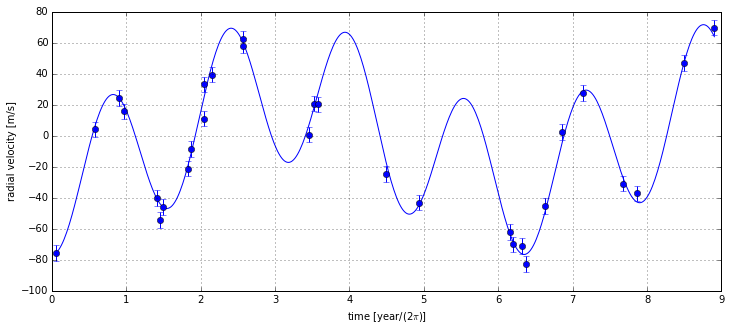

In [5]:
Nplanets = 2
theta_names  = ["a_1", "anom_1","a_2", "anom_2"]
theta_test   =  [1.,0.,.4,0.,]
generateObs(theta_test,data_N=30)
fig1 = plt.figure(figsize=(12,5))
times = np.linspace(data_t[0],data_t[-1],500)
plt.plot(times, getRV(theta_test,times=times), color="b");
plt.ylabel("radial velocity [m/s]"); plt.xlabel("time [year/(2$\pi$)]")
plt.errorbar(data_t, data_rv, yerr=data_err, fmt="bo")
plt.grid()


## Helper functions
Two more helper functions. These find the right location in the particle array for the a given index for the first order variational equations and for two given indicies for the second order variational equations. 

In [6]:
def varid2(l,k):
    N = Nplanets+1
    if k>l:
        raise Exception("error")
    if l>=N_param:
        raise Exception("error")
    var = l*(l+1)/2+k
    return var*N+N+N*N_param
def varid1(l):
    N = Nplanets+1
    if l>=N_param:
        raise Exception("error")
    return N*l+N

## Simulation
This is the work-horse function which sets up and runs a simulation using the parameters `thetas`. It returns logp and its first two derivatives with respect to `thetas`.

Currently, all the variational equations are calculate with the same initial `delta`. This is not good and should be changed. Something like `delta` times the current value might make sense. But one has to make sure there are no issues due to limited floating point precision. 

In [7]:
def move_var_to_com(varoffset):
    ps = r.particles
    m = 0.
    x = 0.
    y = 0.
    z = 0.
    vx = 0.
    vy = 0.
    vz = 0.
    for i in range(Nplanets+1):
        m  += (ps[i].m+ps[i+varoffset].m)
        x  += (ps[i].x+ps[i+varoffset].x)  *(ps[i].m+ps[i+varoffset].m)
        y  += (ps[i].y+ps[i+varoffset].y)  *(ps[i].m+ps[i+varoffset].m)
        z  += (ps[i].z+ps[i+varoffset].z)  *(ps[i].m+ps[i+varoffset].m)
        vx += (ps[i].vx+ps[i+varoffset].vx)*(ps[i].m+ps[i+varoffset].m)
        vy += (ps[i].vy+ps[i+varoffset].vy)*(ps[i].m+ps[i+varoffset].m)
        vz += (ps[i].vz+ps[i+varoffset].vz)*(ps[i].m+ps[i+varoffset].m)
    if m>0.:
        x /= m
        y /= m
        z /= m
        vx /= m
        vy /= m
        vz /= m
    for i in range(Nplanets+1):    
        ps[i+varoffset].x  -= x
        ps[i+varoffset].y  -= y
        ps[i+varoffset].z  -= z
        ps[i+varoffset].vx -= vx
        ps[i+varoffset].vy -= vy
        ps[i+varoffset].vz -= vz    
        
def simulation(thetas):
    r.reset()
    r.N_megnopp = N_param 
    r.add(m=1.)
    op = particleSetupDict(thetas)
    r.add(op)
    r.move_to_com()
    N = r.N
    r.init_megno(0.)
    ps = r.particles
    
    delta = 1e-4
    # First order
    for l in range(N_param):
        thetas2 = thetas.copy()
        thetas2[l] += delta/2.
        mp = particleSetupDict(thetas2)
        thetas2 = thetas.copy()
        thetas2[l] -= delta/2.
        mm = particleSetupDict(thetas2)

        vari = varid1(l)
        for i in range(Nplanets):
            ps[vari+i+1].m  = mp[i].m  - mm[i].m  
            ps[vari+i+1].x  = mp[i].x  - mm[i].x  
            ps[vari+i+1].y  = mp[i].y  - mm[i].y  
            ps[vari+i+1].z  = mp[i].z  - mm[i].z  
            ps[vari+i+1].vx = mp[i].vx - mm[i].vx 
            ps[vari+i+1].vy = mp[i].vy - mm[i].vy 
            ps[vari+i+1].vz = mp[i].vz - mm[i].vz 
        
        move_var_to_com(vari)
        
    # Second order
    for l in range(N_param):
        for k in range(l+1):
            fac = 2.
            thetas2 = thetas.copy()
            thetas2[l] += delta/fac
            thetas2[k] += delta/fac
            mpp = particleSetupDict(thetas2)
            thetas2 = thetas.copy()
            thetas2[l] += delta/fac
            thetas2[k] -= delta/fac
            mpm = particleSetupDict(thetas2)
            thetas2 = thetas.copy()
            thetas2[l] -= delta/fac
            thetas2[k] += delta/fac
            mmp = particleSetupDict(thetas2)
            thetas2 = thetas.copy()
            thetas2[l] -= delta/fac
            thetas2[k] -= delta/fac
            mmm = particleSetupDict(thetas2)
            
            vari2 = varid2(l,k)
            for i in range(Nplanets):
                ps[vari2+i+1].m  = mpp[i].m  - mpm[i].m  - mmp[i].m  + mmm[i].m
                ps[vari2+i+1].x  = mpp[i].x  - mpm[i].x  - mmp[i].x  + mmm[i].x
                ps[vari2+i+1].y  = mpp[i].y  - mpm[i].y  - mmp[i].y  + mmm[i].y 
                ps[vari2+i+1].z  = mpp[i].z  - mpm[i].z  - mmp[i].z  + mmm[i].z 
                ps[vari2+i+1].vx = mpp[i].vx - mpm[i].vx - mmp[i].vx + mmm[i].vx
                ps[vari2+i+1].vy = mpp[i].vy - mpm[i].vy - mmp[i].vy + mmm[i].vy
                ps[vari2+i+1].vz = mpp[i].vz - mpm[i].vz - mmp[i].vz + mmm[i].vz
    
            move_var_to_com(vari2)

    
    ##################################################################
    # INTEGRATION
    logps   = 0.
    logp_d  = np.zeros(N_param)
    logp_d2 = np.zeros((N_param*(N_param+1)/2,2))
    for i,t in enumerate(data_t):
        r.integrate(t)
        dv = ps[0].vx*CU2MS-data_rv[i]
        derri = 1./(2.*(data_err[i]**2))
        logps  += -dv**2*derri
        for k in range(N_param):
            vari1 = varid1(k)
            logp_d[k] += -2.*ps[vari1].vx*CU2MS/delta * dv*derri
        _id = 0
        for l in range(N_param):
            for k in range(l+1):
                vari2 = varid2(l,k)
                vari1l = varid1(l)
                vari1k = varid1(k)
                logp_d2[_id][0] += -2.*(ps[vari1l].vx*CU2MS * ps[vari1k].vx*CU2MS)/(delta*delta)*derri
                # Expectation value would remove next line, still a valid metric, but less useful
                logp_d2[_id][1] += -2.*(ps[vari2].vx*CU2MS * dv)/(delta*delta)*derri
                _id += 1
    
    logp_d2m = np.zeros((N_param,N_param))
    _id = 0
    for l in range(N_param):
        for k in range(l+1):
            fdd = logp_d2[_id][0] + logp_d2[_id][1]
            logp_d2m[l,k] = fdd
            logp_d2m[k,l] = fdd
            _id +=1
    
    return logps, logp_d, logp_d2m

## Soft-abs metric
The following function implements the soft-abs metric. This makes sure the metric is positive definite and well behaved. I'm not sure yet how to choose `alpha`.

In [8]:
def softabs(hessians):
    lam, Q = np.linalg.eig(-hessians)
    lam_twig = lam*1./np.tanh(alpha*lam)
    H_twig = np.dot(Q,np.dot(np.diag(lam_twig),Q.T))    
    return H_twig

## MCMC loop
This function is the actual MCMC loop. It can be optimized, but it works. It would probably make sense to have some sort of "state object".

In [9]:
class State:  
    def __init__(self, thetai, epsiloni):
        self.theta    = thetai
        self.epsilon  = epsiloni
        self.logp, self.gradient, self.hessian = simulation(self.theta)
        self.G        = softabs(self.hessian)
        self.Ginv     = np.linalg.inv(self.G)
        self.Ginvsqrt = np.linalg.cholesky(self.Ginv)    
        self.mu       = self.theta + (self.epsilon)**2 * np.dot(self.Ginv, self.gradient)/2.
        
    def generateProposal(self):
        thetastar = self.mu + (self.epsilon) * np.dot(self.Ginvsqrt, np.random.normal(0.,1.,N_param))
        return State(thetastar,self.epsilon)
    
    def transitionProbability(self,thetaNew):
        return stats.multivariate_normal.logpdf(thetaNew,mean=self.mu, cov=(self.epsilon)**2*self.Ginv)
    
def mcmc(theta,N_steps,epsilon):
    errs = np.zeros(N_steps)
    chain = np.zeros((N_steps,N_param))
    state = State(np.array(theta),epsilon)
    accepted = 0
    for i in range(N_steps):
        stateStar = state.generateProposal()

        q_ts_t = state.transitionProbability(stateStar.theta)
        q_t_ts = stateStar.transitionProbability(state.theta)
        
        if np.exp(stateStar.logp-state.logp+q_t_ts-q_ts_t) > np.random.uniform():
            accepted += 1
            state = stateStar
        chain[i] = state.theta
        errs[i] = state.logp

    print "Acceptance rate: %.1f%%" % (float(accepted)/float(N_steps)*100.)
    return errs, chain
    

## Run!!
Let's setup all parameters, create fake observations and run the MCMC

In [ ]:
N_steps                  = 5000
alpha                    = 1000.1         # softabs alpha
theta_names              = ["a_1", "m_1", "anom_1", "a_2", "m_2", "anom_2"]
theta_actual             = [1., 1e-3, 1., 0.5, 1e-3, 0.3]
theta_initial            = [1., 1e-3, 1., 0.5, 1e-3, 0.3]  # only slightly different, i.e. a pretty good guess

# Generate fake observations and run MCMC
generateObs(theta_actual,data_N=30)
errs, chain = mcmc(theta_initial,N_steps, epsilon=0.75)

Note the high acceptance rate above!

## Plots
Let's plot the evolution of the chain: logp, and all parameters. Green lines correspond to the actual values used to generate the observations.

In [ ]:
fig1 = plt.figure(figsize=(12,5))
plt.xlabel("iteration"); plt.ylabel("logp");
plt.plot(range(N_steps), errs, color="b");
plt.grid()
for i in range(N_param):
    fig1 = plt.figure(figsize=(12,5))
    plt.xlabel("iteration"); plt.ylabel(theta_names[i]);
    plt.plot(range(N_steps), chain[:,i], color="b");
    plt.plot([0,N_steps-1], [theta_actual[i],theta_actual[i]], color="g");
    plt.grid()

Autocorrelation plots

In [ ]:
def autocorr(x):
    result = np.correlate(x, x, mode="full")
    return result[result.size/2:]
    
for i in range(N_param):
    fig1 = plt.figure(figsize=(12,5))
    cor = autocorr(chain[:,i]-np.mean(chain[:,i]))
    cor = cor/cor[0]
    plt.xlabel("iteration"); plt.ylabel("autocor("+theta_names[i]+")");
    showSteps = min(300,N_steps)
    half = 0
    for i,c in enumerate(cor):
        if c<0.5:
            half = i
            break
    plt.axvline(half, color="r")
    plt.axhline(0.5, color="r")
    plt.plot(range(N_steps)[:showSteps], cor[:showSteps], color="b");
    plt.xticks(list(plt.xticks()[0])+[half])
    plt.grid()

Let's make a triangle plot of the distributions. The plot also shows the actual (true) values.

In [ ]:
import triangle
figure = triangle.corner(chain, labels=theta_names, truths=theta_actual)

To inspect the evolution, here is a dynamic widget plot, the slider can be used to scan through the iterations and compare the RV curve to the actual observations (only works in an active jupyter notebook).

In [ ]:
from IPython.html.widgets import interact, interactive
from IPython.display import display
times = np.linspace(data_t[0],data_t[-1],500)

def widgetplot(ind):
    fig1 = plt.figure(figsize=(12,5))
    plt.ylabel("radial velocity [m/s]"); plt.xlabel("time [year/(2$\pi$)]")
    plt.errorbar(data_t, data_rv, yerr=data_err, fmt="go")
    plt.plot(times, getRV(theta_actual, times=times), color="g");
    plt.plot(times, getRV(chain[int(ind),:], times=times), color="b");
    plt.grid()

display(interactive(widgetplot, ind=(0,N_steps-1)))